<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/PositionalEncodingExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sorry, this ones kind of a mess. There are a few passes in this notebook of different manifestations of encoding approaches as per AI generation from various different models.


# Addative sinusoidal embedding

In [ ]:
import torch
import torch.nn as nn
import math
import random

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 64
epochs = 1
num_layers = 2

# --- Data: Predict index of max token ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- Sinusoidal Positional Encoding ---
def sinusoidal_encoding(seq_len, d_model, device):
    position = torch.arange(seq_len, dtype=torch.float, device=device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(seq_len, d_model, device=device)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe  # [seq_len, d_model]

# --- Transformer Model ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, seq_len, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_enc = sinusoidal_encoding(seq_len, d_model, device)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)
        pos = self.pos_enc[:x.size(1)]
        tok = tok + pos
        for layer in self.layers:
            tok = layer(tok)
        logits = self.classifier(tok).squeeze(-1)  # [B, T]
        return logits

# --- Train ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
model = MaxIndexTransformer(seq_len=train_seq_len, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)

Eval acc at seq_len=64: 0.984


0.984000027179718

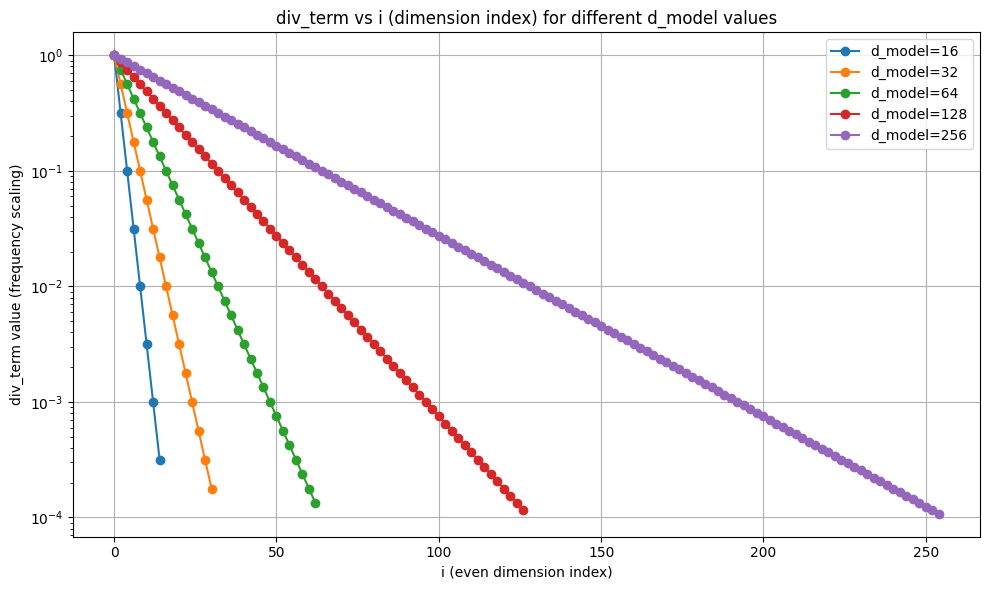

In [ ]:
import torch
import math
import matplotlib.pyplot as plt

def compute_div_term(d_model):
    i = torch.arange(0, d_model, 2)
    div_term = torch.exp(i * (-math.log(10000.0) / d_model))
    return i, div_term

# List of different d_model sizes to compare
d_models = [16, 32, 64, 128, 256]
plt.figure(figsize=(10, 6))

for d_model in d_models:
    i, div_term = compute_div_term(d_model)
    plt.plot(i.numpy(), div_term.numpy(), label=f'd_model={d_model}', marker='o')

plt.title("div_term vs i (dimension index) for different d_model values")
plt.xlabel("i (even dimension index)")
plt.ylabel("div_term value (frequency scaling)")
plt.yscale('log')  # Makes it easier to see the exponential drop-off
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


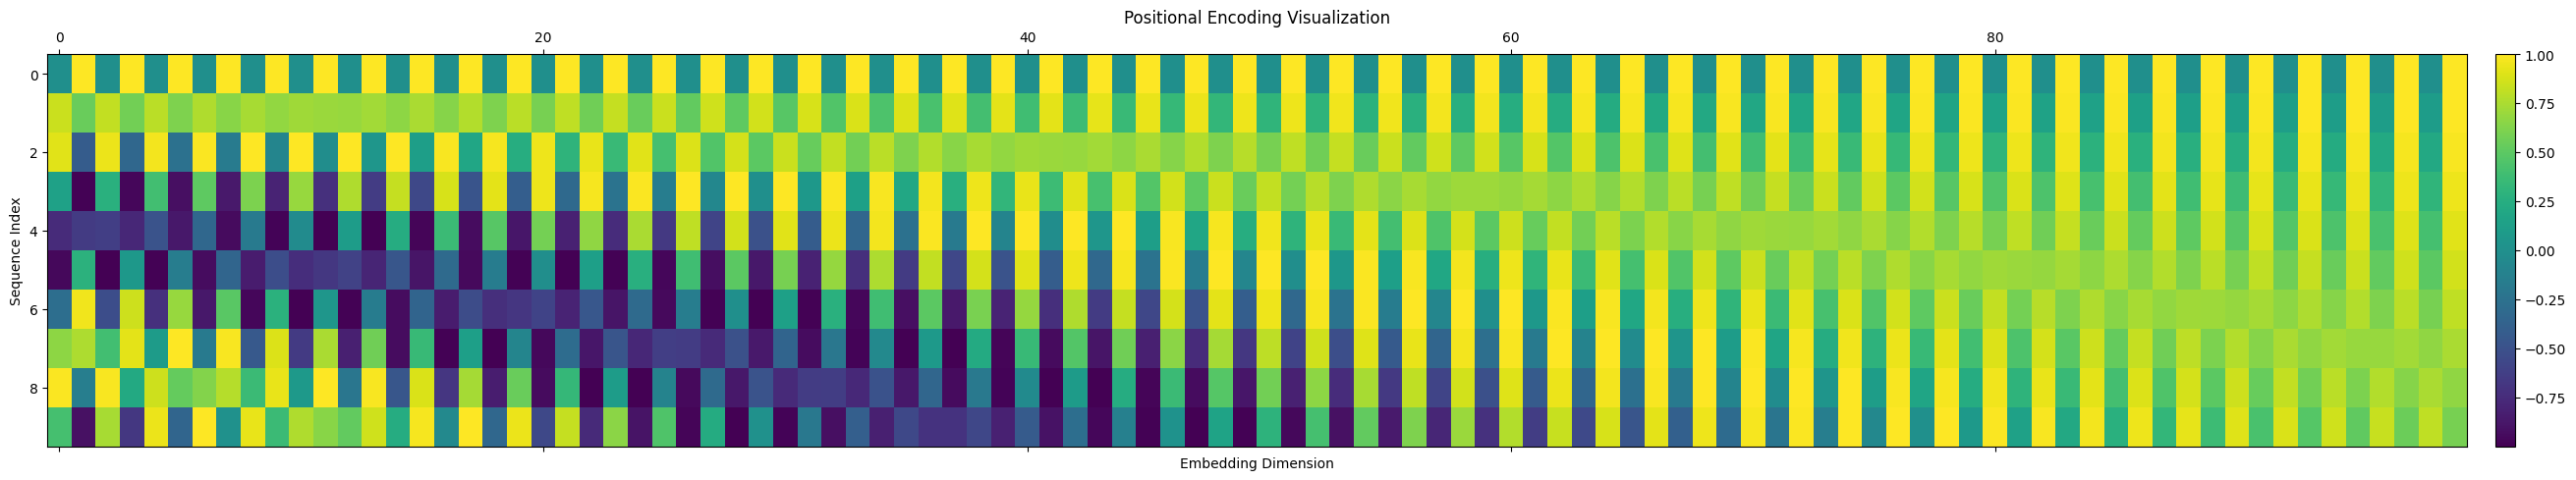

In [ ]:
"""
Plotting positional encoding for each index.
A positional encoding for a single token would be a horizontal row in the image

inspired by https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
"""

import numpy as np
import matplotlib.pyplot as plt

# These would be defined based on the vector embedding and sequence
sequence_length = 10
embedding_dimension = 100

# Generating positional encodings
def gen_positional_encodings(sequence_length, embedding_dimension):
    positional_encodings = np.zeros((sequence_length, embedding_dimension))

    for i in range(sequence_length):
        for j in np.arange(int(embedding_dimension / 2)):
            denominator = np.power(sequence_length, 2 * j / embedding_dimension)
            positional_encodings[i, 2 * j] = np.sin(i / denominator)
            positional_encodings[i, 2 * j + 1] = np.cos(i / denominator)

    return positional_encodings

# Rendering
fig, ax = plt.subplots(figsize=(30, 5))  # wider plot
ax.set_ylabel('Sequence Index')
ax.set_xlabel('Embedding Dimension')
cax = ax.matshow(gen_positional_encodings(sequence_length, embedding_dimension), aspect='auto')
fig.colorbar(cax, pad=0.01)
plt.title("Positional Encoding Visualization")
plt.tight_layout()
plt.show()

# Learned Positional Encoding

In [ ]:
import torch
import torch.nn as nn
import random

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 64
epochs = 10
num_layers = 2

# --- Data: Predict index of max token ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- Transformer with Learned Positional Embedding ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, seq_len, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        tok = self.token_emb(x) + self.pos_emb(positions)
        for layer in self.layers:
            tok = layer(tok)
        logits = self.classifier(tok).squeeze(-1)  # [B, T]
        return logits

# --- Train ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
model = MaxIndexTransformer(seq_len=train_seq_len, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)         # Evaluate at training length

Eval acc at seq_len=64: 0.996


0.9960000514984131

# Relative Positional Encoding

In [ ]:
import torch
import torch.nn as nn
import math

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 64
epochs = 10
num_layers = 2

# --- Data: Predict index of max token ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- Relative Multihead Attention ---
class RelMultiheadAttention(nn.Module):
    def __init__(self, d_model, n_heads, seq_len):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.seq_len = seq_len

        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        self.rel_pos_emb = nn.Parameter(torch.randn(2 * seq_len - 1, self.head_dim))  # relative positions

    def forward(self, x):
        B, T, _ = x.size()
        qkv = self.qkv_proj(x).reshape(B, T, self.n_heads, 3 * self.head_dim)
        q, k, v = torch.chunk(qkv, 3, dim=-1)

        q = q.transpose(1, 2)  # [B, H, T, D]
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Compute relative positional attention
        rel_pos = self._relative_logits(q)

        # Content-based attention
        attn_logits = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn_logits += rel_pos

        attn_weights = torch.softmax(attn_logits, dim=-1)
        out = torch.matmul(attn_weights, v)  # [B, H, T, D]
        out = out.transpose(1, 2).reshape(B, T, self.d_model)
        return self.out_proj(out)

    def _relative_logits(self, q):
        B, H, T, D = q.size()
        range_vec = torch.arange(T, device=q.device)
        distance_mat = range_vec[None, :] - range_vec[:, None]  # [T, T]
        distance_mat += self.seq_len - 1  # shift so all indices are positive
        rel_embeddings = self.rel_pos_emb[distance_mat]  # [T, T, D]

        logits = torch.einsum('bhtd,tsd->bhts', q, rel_embeddings) / math.sqrt(D)
        return logits

# --- Transformer Encoder Layer with Relative Attention ---
class RelTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, seq_len):
        super().__init__()
        self.self_attn = RelMultiheadAttention(d_model, n_heads, seq_len)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.self_attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

# --- Transformer Model with Relative Positional Encoding ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, seq_len, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            RelTransformerEncoderLayer(d_model, n_heads, seq_len)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)
        for layer in self.layers:
            tok = layer(tok)
        logits = self.classifier(tok).squeeze(-1)  # [B, T]
        return logits

# --- Train ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
model = MaxIndexTransformer(seq_len=train_seq_len, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)

Eval acc at seq_len=64: 0.998


0.9980000257492065

# T5 (Bucket Relative Bias)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
seq_len = 64
epochs = 1
num_train = 256
batch_size = 32

# --- Toy Data: Predict index of max token ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)  # index of max token
    return x.to(device), y.to(device)

# --- T5 Relative Position Bias ---
class T5RelativeBias(nn.Module):
    def __init__(self, num_buckets=32, max_distance=128):
        super().__init__()
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.relative_attention_bias = nn.Embedding(num_buckets, 1)

    def _relative_position_bucket(self, relative_position):
        num_buckets = self.num_buckets
        max_exact = num_buckets // 2
        n = -relative_position
        is_small = n < max_exact
        val_if_large = max_exact + (
            (torch.log(n.float() / max_exact + 1e-6) / math.log(self.max_distance / max_exact)) *
            (num_buckets - max_exact)
        ).long()
        val_if_large = torch.min(val_if_large, torch.full_like(val_if_large, num_buckets - 1))
        return torch.where(is_small, n, val_if_large)

    def forward(self, qlen, klen, device):
        context_pos = torch.arange(qlen, dtype=torch.long, device=device)[:, None]
        memory_pos = torch.arange(klen, dtype=torch.long, device=device)[None, :]
        rel_pos = memory_pos - context_pos  # [qlen, klen]
        buckets = self._relative_position_bucket(rel_pos)
        bias = self.relative_attention_bias(buckets).squeeze(-1)  # [qlen, klen]
        return bias

# --- Self-Attention with Relative Bias ---
class SimpleSelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x, rel_bias):
        Q = self.q_proj(x)  # [B, T, D]
        K = self.k_proj(x)
        V = self.v_proj(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(Q.size(-1))  # [B, T, T]
        scores += rel_bias.unsqueeze(0)  # [1, T, T]
        attn_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, V)
        return self.out_proj(output)

# --- Transformer Layer ---
class SimpleTransformerLayer(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attn = SimpleSelfAttention(d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model),
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, rel_bias):
        x = x + self.attn(self.norm1(x), rel_bias)
        x = x + self.ff(self.norm2(x))
        return x

# --- Final Model ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.rel_bias = T5RelativeBias()
        self.layer = SimpleTransformerLayer(d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        B, T = x.size()
        if x.max() >= vocab_size:
            raise ValueError(f"Invalid token index in input! max(x)={x.max().item()}")
        x = self.token_emb(x)  # [B, T, D]
        bias = self.rel_bias(T, T, x.device)  # [T, T]
        x = self.layer(x, bias)  # [B, T, D]
        logits = self.classifier(x).squeeze(-1)  # [B, T]
        return logits

# --- Train ---
def train(model, optimizer, criterion):
    model.train()
    for epoch in range(epochs):
        for step in range(num_train // batch_size):
            x, y = generate_batch(batch_size, seq_len)
            logits = model(x)

            # --- Defensive Checks ---
            assert not logits.isnan().any(), "NaNs in logits!"
            assert y.max().item() < logits.shape[1], f"Target index {y.max().item()} >= {logits.shape[1]}"
            assert y.min().item() >= 0, f"Negative target index {y.min().item()}"

            loss = criterion(logits, y)
            if step % 10 == 0:
                print(f"Epoch {epoch} Step {step}: Loss = {loss.item():.4f}")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluate ---
@torch.no_grad()
def evaluate(model):
    model.eval()
    x, y = generate_batch(64, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")

# --- Run ---
model = MaxIndexTransformer(seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 64
epochs = 1
num_layers = 2

# --- Data: Predict index of max token ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- T5 Relative Positional Bias ---
class T5RelativePositionalBias(nn.Module):
    def __init__(self, n_heads, num_buckets=32, max_distance=128):
        super().__init__()
        self.n_heads = n_heads
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.relative_attention_bias = nn.Embedding(num_buckets, n_heads)

    def _relative_position_bucket(self, relative_position):
        num_buckets = self.num_buckets
        max_distance = self.max_distance

        # Bidirectional bucketing
        num_buckets //= 2
        relative_buckets = (relative_position > 0).to(torch.long) * num_buckets
        relative_position = torch.abs(relative_position)

        # Small positions map directly to buckets
        max_exact = num_buckets // 2
        is_small = relative_position < max_exact

        # Large positions get log-scaled buckets
        relative_position_if_large = max_exact + (
            torch.log(relative_position.float() / max_exact) /
            math.log(max_distance / max_exact) * (num_buckets - max_exact)
        ).to(torch.long)
        relative_position_if_large = torch.min(
            relative_position_if_large,
            torch.full_like(relative_position, num_buckets - 1)
        )

        # Combine buckets
        relative_buckets += torch.where(is_small, relative_position, relative_position_if_large)
        return relative_buckets

    def forward(self, seq_len):
        q_pos = torch.arange(seq_len, dtype=torch.long, device=self.relative_attention_bias.weight.device)
        rel_pos = q_pos[:, None] - q_pos[None, :]
        buckets = self._relative_position_bucket(rel_pos)
        bias = self.relative_attention_bias(buckets)  # [T, T, H]
        return bias.permute(2, 0, 1).unsqueeze(0)    # [1, H, T, T]

# --- T5 Transformer Layer ---
class T5TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Attention projections
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        # FFN
        self.ffn = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )

        self.dropout = nn.Dropout(dropout)
        self.head_dim = d_model // n_heads

    def forward(self, x, relative_attention_bias):
        # Pre-LayerNorm attention
        residual = x
        x_norm = self.norm1(x)

        # Project to query/key/value
        B, T, _ = x_norm.shape
        q = self.q_proj(x_norm).view(B, T, n_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x_norm).view(B, T, n_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x_norm).view(B, T, n_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn_scores = attn_scores + relative_attention_bias

        # Attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Context
        context = torch.matmul(attn_weights, v)
        context = context.transpose(1, 2).contiguous().view(B, T, -1)
        context = self.out_proj(context)

        # Residual connection
        x = residual + self.dropout(context)

        # FFN with residual
        x = x + self.ffn(self.norm2(x))
        return x

# --- Transformer Model ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, seq_len, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.relative_bias = T5RelativePositionalBias(n_heads)
        self.layers = nn.ModuleList([
            T5TransformerEncoderLayer(d_model, n_heads)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)
        T = x.size(1)
        rel_bias = self.relative_bias(T)

        for layer in self.layers:
            tok = layer(tok, rel_bias)

        tok = self.norm(tok)
        logits = self.classifier(tok).squeeze(-1)
        return logits

# --- Train ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
model = MaxIndexTransformer(seq_len=train_seq_len, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)

Eval acc at seq_len=64: 0.852


0.8520000576972961

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 64
epochs = 1
num_layers = 2

# --- Data: Predict index of max token ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- T5 Relative Positional Bias ---
class T5RelativePositionalBias(nn.Module):
    def __init__(self, n_heads, num_buckets=32, max_distance=128):
        super().__init__()
        self.n_heads = n_heads
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.relative_attention_bias = nn.Embedding(num_buckets, n_heads)

    def _relative_position_bucket(self, relative_position):
        num_buckets = self.num_buckets
        max_distance = self.max_distance

        # Bidirectional bucketing
        num_buckets //= 2
        relative_buckets = (relative_position > 0).to(torch.long) * num_buckets
        relative_position = torch.abs(relative_position)

        # Small positions map directly to buckets
        max_exact = num_buckets // 2
        is_small = relative_position < max_exact

        # Large positions get log-scaled buckets
        relative_position_if_large = max_exact + (
            torch.log(relative_position.float() / max_exact) /
            math.log(max_distance / max_exact) * (num_buckets - max_exact)
        ).to(torch.long)
        relative_position_if_large = torch.min(
            relative_position_if_large,
            torch.full_like(relative_position, num_buckets - 1)
        )

        # Combine buckets
        relative_buckets += torch.where(is_small, relative_position, relative_position_if_large)
        return relative_buckets

    def forward(self, seq_len):
        q_pos = torch.arange(seq_len, dtype=torch.long, device=self.relative_attention_bias.weight.device)
        rel_pos = q_pos[:, None] - q_pos[None, :]
        buckets = self._relative_position_bucket(rel_pos)
        bias = self.relative_attention_bias(buckets)  # [T, T, H]
        return bias.permute(2, 0, 1).unsqueeze(0)    # [1, H, T, T]

# --- T5 Transformer Layer ---
class T5TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Attention projections
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        self.head_dim = d_model // n_heads

    def forward(self, x, relative_attention_bias):
        # Pre-LayerNorm attention
        residual = x
        x_norm = self.norm1(x)

        # Project to query/key/value
        B, T, _ = x_norm.shape
        q = self.q_proj(x_norm).view(B, T, n_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x_norm).view(B, T, n_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x_norm).view(B, T, n_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn_scores = attn_scores + relative_attention_bias

        # Attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)

        # Context
        context = torch.matmul(attn_weights, v)
        context = context.transpose(1, 2).contiguous().view(B, T, -1)
        context = self.out_proj(context)

        # Residual connection
        x = residual + context

        # Final LayerNorm (no FFN)
        x = x + self.norm2(x)
        return x

# --- Transformer Model ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, seq_len, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.relative_bias = T5RelativePositionalBias(n_heads)
        self.layers = nn.ModuleList([
            T5TransformerEncoderLayer(d_model, n_heads)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)
        T = x.size(1)
        rel_bias = self.relative_bias(T)

        for layer in self.layers:
            tok = layer(tok, rel_bias)

        tok = self.norm(tok)
        logits = self.classifier(tok).squeeze(-1)
        return logits

# --- Train ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
model = MaxIndexTransformer(seq_len=train_seq_len, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)

Eval acc at seq_len=64: 0.788


0.7880000472068787

# DeBERTa

In [ ]:
import torch
import torch.nn as nn
import math

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 64
epochs = 10
num_layers = 2

# --- Data: Predict index of max token ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- DeBERTa-style Multihead Attention ---
class DisentangledSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, seq_len):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.head_dim = d_model // n_heads
        self.seq_len = seq_len

        assert d_model % n_heads == 0

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)

        self.pos_proj = nn.Linear(d_model, d_model)  # for disentangled position encoding
        self.pos_emb = nn.Embedding(2 * seq_len - 1, d_model)

        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, _ = x.size()
        device = x.device

        q = self.q_proj(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)  # [B, H, T, D]
        k = self.k_proj(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        # Relative positional embeddings
        pos_ids = torch.arange(T, device=device).unsqueeze(1) - torch.arange(T, device=device).unsqueeze(0)  # [T, T]
        pos_ids += self.seq_len - 1  # shift to positive range
        rel_pos = self.pos_emb(pos_ids)  # [T, T, D]
        rel_pos = self.pos_proj(rel_pos)  # [T, T, D]
        rel_pos = rel_pos.view(T, T, self.n_heads, self.head_dim).permute(2, 0, 1, 3)  # [H, T, T, D]

        # Attention: Content-to-Content
        ac = torch.matmul(q, k.transpose(-2, -1))  # [B, H, T, T]

        # Attention: Content-to-Position
        bd = torch.einsum('bhtd,htsd->bhts', q, rel_pos)  # [B, H, T, T]

        attn = (ac + bd) / math.sqrt(self.head_dim)
        attn = torch.softmax(attn, dim=-1)
        out = torch.matmul(attn, v)  # [B, H, T, D]

        out = out.transpose(1, 2).contiguous().view(B, T, self.d_model)
        return self.out_proj(out)

# --- Transformer Encoder Layer with Disentangled Attention ---
class DebertaEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, seq_len):
        super().__init__()
        self.self_attn = DisentangledSelfAttention(d_model, n_heads, seq_len)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.self_attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

# --- Transformer Model with DeBERTa-style Positional Encoding ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, seq_len, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            DebertaEncoderLayer(d_model, n_heads, seq_len)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)  # [B, T, D]
        for layer in self.layers:
            tok = layer(tok)
        tok = self.norm(tok)
        logits = self.classifier(tok).squeeze(-1)  # [B, T]
        return logits

# --- Train ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
model = MaxIndexTransformer(seq_len=train_seq_len, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)

Eval acc at seq_len=64: 1.000


1.0

# Rotary Positional Encoding

In [ ]:
import torch
import torch.nn as nn
import math

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 256
epochs = 10
num_layers = 2

# --- Data: Predict index of max token ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- RoPE ---
def apply_rope(x):
    b, seq_len, d = x.shape
    assert d % 2 == 0
    half_d = d // 2
    x = x.view(b, seq_len, half_d, 2)

    freqs = torch.arange(half_d, device=x.device).float()
    theta = 10000 ** (-freqs / half_d)
    pos = torch.arange(seq_len, device=x.device).float()
    angles = torch.einsum("s,f->sf", pos, theta)

    cos = torch.cos(angles).unsqueeze(0).unsqueeze(-1)
    sin = torch.sin(angles).unsqueeze(0).unsqueeze(-1)

    x1 = x[..., 0:1] * cos - x[..., 1:2] * sin
    x2 = x[..., 0:1] * sin + x[..., 1:2] * cos

    x_rot = torch.cat([x1, x2], dim=-1)
    return x_rot.view(b, seq_len, d)

# --- RoPE-aware Multihead Attention ---
class RoPEAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x
        x = apply_rope(x)
        x, _ = self.attn(x, x, x)
        return self.norm(x + residual)

# --- Transformer Encoder Layer ---
class RoPEEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.self_attn = RoPEAttention(d_model, n_heads)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.self_attn(x)
        x = x + self.ff(self.norm(x))
        return x

# --- Transformer Model with RoPE ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, seq_len, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            RoPEEncoderLayer(d_model, n_heads) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)
        for layer in self.layers:
            tok = layer(tok)
        tok = self.norm(tok)
        logits = self.classifier(tok).squeeze(-1)  # [B, T]
        return logits

# --- Train ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
model = MaxIndexTransformer(seq_len=train_seq_len, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)

Eval acc at seq_len=64: 1.000


1.0

Training model: Learned Pos Emb
Training model: RoPE


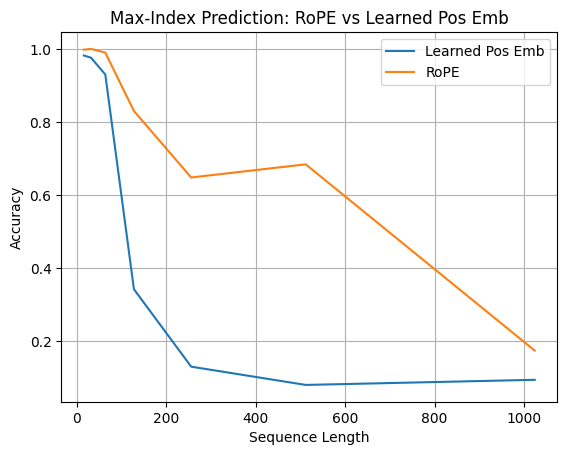

In [ ]:
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
max_train_len = 64
max_test_len = 1024
num_train = 30000
num_test = 500
batch_size = 256
epochs = 10
num_layers = 2

# --- Data: Find index of max token ---
def generate_batch(num, seq_len):
    inputs = torch.randint(1, vocab_size, (num, seq_len))
    targets = torch.argmax(inputs, dim=1)
    return inputs.to(device), targets.to(device)

# --- RoPE ---
def apply_rope(x):
    b, seq_len, d = x.shape
    assert d % 2 == 0
    half_d = d // 2
    x = x.view(b, seq_len, half_d, 2)

    freqs = torch.arange(half_d, device=x.device).float()
    theta = 10000 ** (-freqs / half_d)
    pos = torch.arange(seq_len, device=x.device).float()
    angles = torch.einsum("s,f->sf", pos, theta)

    cos = torch.cos(angles).unsqueeze(0).unsqueeze(-1)
    sin = torch.sin(angles).unsqueeze(0).unsqueeze(-1)

    x1 = x[..., 0:1] * cos - x[..., 1:2] * sin
    x2 = x[..., 0:1] * sin + x[..., 1:2] * cos

    x_rot = torch.cat([x1, x2], dim=-1)
    return x_rot.view(b, seq_len, d)

# --- Custom Attention Layer (with optional RoPE) ---
class CustomAttentionLayer(nn.Module):
    def __init__(self, d_model, n_heads, use_rope=False):
        super().__init__()
        self.use_rope = use_rope
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x
        if self.use_rope:
            x = apply_rope(x)
        x, _ = self.attn(x, x, x)
        return self.norm(x + residual)

# --- Transformer Model ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, use_rope=False, max_len=128, num_layers=2):
        super().__init__()
        self.use_rope = use_rope
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.randn(max_len, d_model)) if not use_rope else None

        self.layers = nn.ModuleList([
            CustomAttentionLayer(d_model=d_model, n_heads=n_heads, use_rope=use_rope)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)
        if not self.use_rope:
            pos = self.pos_emb[:x.size(1)]
            tok = tok + pos

        for layer in self.layers:
            tok = layer(tok)

        logits = self.classifier(tok).squeeze(-1)  # shape: [B, T]
        return logits

# --- Training ---
def train_model(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, random.randint(4, max_train_len))
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluation ---
@torch.no_grad()
def evaluate_model(model, lengths=[16, 32, 64, 128, 256, 512, 1024]):
    model.eval()
    accs = []
    for L in lengths:
        x, y = generate_batch(num_test, L)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean().item()
        accs.append(acc)
    return accs

# --- Run Experiment ---
results = {}
for name, use_rope in [("Learned Pos Emb", False), ("RoPE", True)]:
    print(f"Training model: {name}")
    model = MaxIndexTransformer(
        use_rope=use_rope,
        max_len=max_test_len,
        num_layers=num_layers  # change this to test deeper models
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    train_model(model, optimizer, criterion)
    accs = evaluate_model(model)
    results[name] = accs

# --- Plot Results ---
lengths = [16, 32, 64, 128, 256, 512, 1024]
plt.plot(lengths, results["Learned Pos Emb"], label="Learned Pos Emb")
plt.plot(lengths, results["RoPE"], label="RoPE")
plt.xlabel("Sequence Length")
plt.ylabel("Accuracy")
plt.title("Max-Index Prediction: RoPE vs Learned Pos Emb")
plt.legend()
plt.grid(True)
plt.show()


# Attention with Linear Bias

In [ ]:
import torch
import torch.nn as nn
import math

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 64
epochs = 10
num_layers = 2

# --- Data ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- ALiBi Attention ---
class AlibiAttention(nn.Module):
    def __init__(self, d_model, n_heads, max_len):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.head_dim = d_model // n_heads
        self.max_len = max_len

        assert d_model % n_heads == 0

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        self.register_buffer(
            "alibi_slopes", torch.tensor([2 ** -(8.0 * i / n_heads) for i in range(n_heads)]).view(1, n_heads, 1, 1)
        )

    def forward(self, x):
        B, T, _ = x.size()
        q = self.q_proj(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)  # [B, H, T, D]
        k = self.k_proj(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, H, T, T]

        # Add ALiBi bias
        pos_bias = torch.arange(T, device=x.device).unsqueeze(0) - torch.arange(T, device=x.device).unsqueeze(1)
        pos_bias = pos_bias.clamp(min=0).float().unsqueeze(0).unsqueeze(0)  # [1, 1, T, T]
        alibi_bias = self.alibi_slopes[:, :, :T, :T] * pos_bias  # [1, H, T, T]
        scores = scores + alibi_bias

        attn_weights = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn_weights, v)  # [B, H, T, D]
        out = out.transpose(1, 2).contiguous().view(B, T, self.d_model)
        return self.out_proj(out)

# --- Transformer Encoder Layer ---
class AlibiEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, max_len):
        super().__init__()
        self.attn = AlibiAttention(d_model, n_heads, max_len)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

# --- ALiBi Transformer Model ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, seq_len, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            AlibiEncoderLayer(d_model, n_heads, seq_len)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)  # [B, T, D]
        for layer in self.layers:
            tok = layer(tok)
        tok = self.norm(tok)
        logits = self.classifier(tok).squeeze(-1)  # [B, T]
        return logits

# --- Training ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluation ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
model = MaxIndexTransformer(seq_len=train_seq_len, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)

Eval acc at seq_len=64: 0.990


0.9900000691413879

# XPos

In [ ]:
import torch
import torch.nn as nn
import math

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 64
epochs = 10
num_layers = 2
base = 10000
xpos_scale_base = 512  # controls extrapolation scaling

# --- Data ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- XPos rotary embeddings ---
def apply_xpos(x, scale_base=xpos_scale_base):
    b, seq_len, d = x.shape
    half_d = d // 2
    x = x.view(b, seq_len, half_d, 2)

    # Frequencies
    freqs = torch.arange(half_d, device=x.device).float()
    theta = base ** (-freqs / half_d)
    pos = torch.arange(seq_len, device=x.device).float()

    # Rotation
    angles = torch.einsum("s,f->sf", pos, theta)
    cos = torch.cos(angles).unsqueeze(0).unsqueeze(-1)
    sin = torch.sin(angles).unsqueeze(0).unsqueeze(-1)
    x1 = x[..., 0:1] * cos - x[..., 1:2] * sin
    x2 = x[..., 0:1] * sin + x[..., 1:2] * cos
    x_rot = torch.cat([x1, x2], dim=-1).view(b, seq_len, d)

    # XPos scaling
    scale = (scale_base ** (torch.arange(seq_len, device=x.device) / scale_base)).unsqueeze(0).unsqueeze(-1)
    scale = scale.expand(b, seq_len, d)
    return x_rot * scale

# --- XPos-Aware Attention Layer ---
class XPosAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x
        x = apply_xpos(x)
        x, _ = self.attn(x, x, x)
        return self.norm(x + residual)

# --- Transformer Encoder Layer ---
class XPosEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.self_attn = XPosAttention(d_model, n_heads)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.self_attn(x)
        x = x + self.ff(self.norm(x))
        return x

# --- XPos Transformer Model ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, seq_len, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            XPosEncoderLayer(d_model, n_heads) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)  # [B, T, D]
        for layer in self.layers:
            tok = layer(tok)
        tok = self.norm(tok)
        logits = self.classifier(tok).squeeze(-1)  # [B, T]
        return logits

# --- Training ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluation ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
model = MaxIndexTransformer(seq_len=train_seq_len, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)

Eval acc at seq_len=64: 1.000


1.0

# YaRN

In [ ]:
import torch
import torch.nn as nn
import math

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 64
epochs = 10
num_layers = 2

# --- YaRN config ---
yarn_theta = 10000
yarn_scale = 0.25  # compress frequency spectrum
yarn_clip = 1.0    # clip max freq

# --- Data ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- Apply YaRN (RoPE + scale + clip) ---
def apply_yarn(x):
    b, seq_len, d = x.shape
    assert d % 2 == 0
    half_d = d // 2
    x = x.view(b, seq_len, half_d, 2)

    freqs = torch.arange(half_d, device=x.device).float()
    theta = yarn_theta ** (-freqs / half_d)

    # YaRN frequency compression
    scaled = freqs * yarn_scale
    clipped = torch.clamp(scaled, max=yarn_clip)
    theta_yarn = yarn_theta ** (-clipped)

    pos = torch.arange(seq_len, device=x.device).float()
    angles = torch.einsum("s,f->sf", pos, theta_yarn)

    cos = torch.cos(angles).unsqueeze(0).unsqueeze(-1)
    sin = torch.sin(angles).unsqueeze(0).unsqueeze(-1)

    x1 = x[..., 0:1] * cos - x[..., 1:2] * sin
    x2 = x[..., 0:1] * sin + x[..., 1:2] * cos

    return torch.cat([x1, x2], dim=-1).view(b, seq_len, d)

# --- YaRN-Aware Attention Layer ---
class YaRNAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x
        x = apply_yarn(x)
        x, _ = self.attn(x, x, x)
        return self.norm(x + residual)

# --- Transformer Encoder Layer ---
class YaRNEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.self_attn = YaRNAttention(d_model, n_heads)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.self_attn(x)
        x = x + self.ff(self.norm(x))
        return x

# --- Transformer Model with YaRN ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, seq_len, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            YaRNEncoderLayer(d_model, n_heads) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)
        for layer in self.layers:
            tok = layer(tok)
        tok = self.norm(tok)
        logits = self.classifier(tok).squeeze(-1)
        return logits

# --- Train ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
model = MaxIndexTransformer(seq_len=train_seq_len, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)

Eval acc at seq_len=64: 1.000


1.0

# NTK-aware RoPE

In [ ]:
import torch
import torch.nn as nn
import math

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 64
epochs = 10
num_layers = 2

# --- Data: Predict index of max token ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- RoPE w/ NTK-aware scaling ---
def apply_ntk_rope(x, seq_len, scaling_factor=1.0):
    # x: [B, T, H, D_head] where D_head must be even
    B, T, H, D = x.shape
    assert D % 2 == 0, "D must be even for RoPE"
    half_D = D // 2

    position_ids = torch.arange(T, device=x.device).unsqueeze(1)  # [T, 1]
    dim_ids = torch.arange(half_D, device=x.device).unsqueeze(0)  # [1, D/2]

    base = 10000.0
    # NTK-aware scaling on frequency
    theta = base ** (-2 * dim_ids / (D * scaling_factor))  # [1, D/2]
    freqs = position_ids * theta  # [T, D/2]

    sin, cos = freqs.sin(), freqs.cos()  # [T, D/2]

    # Reshape for broadcasting
    sin = sin[None, :, None, :]  # [1, T, 1, D/2]
    cos = cos[None, :, None, :]

    x1, x2 = x[..., :half_D], x[..., half_D:]
    rotated = torch.cat([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)
    return rotated

# --- Custom Attention with RoPE ---
class NTKRoPEAttention(nn.Module):
    def __init__(self, d_model, n_heads, scaling_factor=1.0):
        super().__init__()
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        self.scaling_factor = scaling_factor

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        q = self.q_proj(x).view(B, T, self.n_heads, self.d_head)
        k = self.k_proj(x).view(B, T, self.n_heads, self.d_head)
        v = self.v_proj(x).view(B, T, self.n_heads, self.d_head)

        # Apply NTK-aware RoPE
        q = apply_ntk_rope(q, T, self.scaling_factor)
        k = apply_ntk_rope(k, T, self.scaling_factor)

        # Attention
        q = q.transpose(1, 2)  # [B, H, T, D]
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_head)  # [B, H, T, T]
        attn_weights = attn_scores.softmax(dim=-1)
        attn_output = torch.matmul(attn_weights, v)  # [B, H, T, D]
        attn_output = attn_output.transpose(1, 2).reshape(B, T, D)

        return self.o_proj(attn_output)

# --- Transformer with NTK-aware RoPE ---
class MaxIndexTransformer(nn.Module):
    def __init__(self, seq_len, num_layers, scaling_factor=1.0):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            nn.Sequential(
                NTKRoPEAttention(d_model, n_heads, scaling_factor),
                nn.LayerNorm(d_model),
                nn.Sequential(
                    nn.Linear(d_model, 4 * d_model),
                    nn.ReLU(),
                    nn.Linear(4 * d_model, d_model),
                ),
                nn.LayerNorm(d_model)
            )
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)
        for attn, norm1, ff, norm2 in self.layers:
            tok = norm1(tok + attn(tok))
            tok = norm2(tok + ff(tok))
        logits = self.classifier(tok).squeeze(-1)  # [B, T]
        return logits

# --- Train ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluate ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
scaling_factor = 1.5  # try 1.0, 1.5, 2.0 to test extrapolation performance
model = MaxIndexTransformer(seq_len=train_seq_len, num_layers=num_layers, scaling_factor=scaling_factor).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)

Eval acc at seq_len=64: 1.000


1.0

# 3D-RPE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 64
epochs = 10
num_layers = 2

# --- Data: Predict index of max token ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- 3D-RPE Bias Generator ---
class ThreeDRPE(nn.Module):
    def __init__(self, max_seq_len, n_heads, d_rpe):
        super().__init__()
        self.max_rel = 2 * max_seq_len - 1
        self.rpe = nn.Embedding(self.max_rel * n_heads, d_rpe)
        self.proj = nn.Linear(d_rpe, 1, bias=False)

        self.max_seq_len = max_seq_len
        self.n_heads = n_heads

    def forward(self, qlen, klen):
        rel_pos = torch.arange(klen)[None, :] - torch.arange(qlen)[:, None]  # [qlen, klen]
        rel_pos = rel_pos.clamp(-self.max_seq_len + 1, self.max_seq_len - 1) + self.max_seq_len - 1

        rpe_biases = []
        for head in range(self.n_heads):
            idx = (rel_pos + head * self.max_rel).to(self.rpe.weight.device)  # <-- FIXED
            emb = self.rpe(idx)  # [qlen, klen, d_rpe]
            bias = self.proj(emb).squeeze(-1)  # [qlen, klen]
            rpe_biases.append(bias)
        stacked = torch.stack(rpe_biases, dim=0)  # [n_heads, qlen, klen]
        return stacked

# --- Custom Transformer Encoder Layer with 3D-RPE ---
class TransformerLayer3DRPE(nn.Module):
    def __init__(self, d_model, n_heads, d_rpe):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.rpe = ThreeDRPE(train_seq_len, n_heads, d_rpe)

    def forward(self, x):
        B, T, _ = x.size()
        rpe_bias = self.rpe(T, T).to(x.device)  # [H, T, T]
        attn_mask = rpe_bias.sum(dim=0)  # naive way to inject 3D-RPE as 2D bias

        attn_output, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = x + attn_output
        x = self.norm1(x)
        x = x + self.ff(x)
        x = self.norm2(x)
        return x

# --- Model ---
class MaxIndexTransformer3DRPE(nn.Module):
    def __init__(self, seq_len, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            TransformerLayer3DRPE(d_model, n_heads, d_rpe=8)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)
        for layer in self.layers:
            tok = layer(tok)
        logits = self.classifier(tok).squeeze(-1)  # [B, T]
        return logits

# --- Training ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluation ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
model = MaxIndexTransformer3DRPE(seq_len=train_seq_len, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)

Eval acc at seq_len=64: 1.000


1.0

# T5 (No Positional Embedding Variant)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Config ---
device = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size = 20
d_model = 16
n_heads = 4
train_seq_len = 64
num_train = 30000
num_test = 500
batch_size = 64
epochs = 10
num_layers = 2

# --- Data: Predict index of max token ---
def generate_batch(num, seq_len):
    x = torch.randint(1, vocab_size, (num, seq_len))
    y = torch.argmax(x, dim=1)
    return x.to(device), y.to(device)

# --- Relative Position Bias like T5 ---
class T5RelativePositionBias(nn.Module):
    def __init__(self, num_heads, max_distance=128, num_buckets=32):
        super().__init__()
        self.num_heads = num_heads
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.relative_attention_bias = nn.Embedding(num_buckets, num_heads)

    def _relative_position_bucket(self, relative_position):
        # Simplified T5 bucketing
        num_buckets = self.num_buckets
        max_exact = num_buckets // 2
        is_small = relative_position < max_exact
        val_if_large = max_exact + (
            (torch.log(relative_position.float() / max_exact + 1e-6) /
             torch.log(torch.tensor(self.max_distance / max_exact))) *
            (num_buckets - max_exact)
        ).long()
        return torch.where(is_small, relative_position, val_if_large.clamp(max=num_buckets - 1))

    def forward(self, qlen, klen):
        context_position = torch.arange(qlen, dtype=torch.long)[:, None]
        memory_position = torch.arange(klen, dtype=torch.long)[None, :]
        relative_position = memory_position - context_position  # shape [qlen, klen]
        relative_position = torch.abs(relative_position)

        rp_bucket = self._relative_position_bucket(relative_position)
        rp_bucket = rp_bucket.to(self.relative_attention_bias.weight.device)  # ✅ Fix

        bias = self.relative_attention_bias(rp_bucket)  # [qlen, klen, num_heads]
        return bias.permute(2, 0, 1)  # [num_heads, qlen, klen]

# --- T5-style Transformer Layer (no position encodings) ---
class TransformerLayerT5(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.rel_bias = T5RelativePositionBias(num_heads=n_heads)

    def forward(self, x):
        B, T, _ = x.size()
        bias = self.rel_bias(T, T).to(x.device)  # [H, T, T]
        bias = bias.mean(0)  # [T, T] — naïvely averaged across heads

        attn_output, _ = self.attn(x, x, x, attn_mask=bias)
        x = x + attn_output
        x = self.norm1(x)
        x = x + self.ff(x)
        x = self.norm2(x)
        return x

# --- Full Model ---
class MaxIndexTransformerT5(nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.layers = nn.ModuleList([
            TransformerLayerT5(d_model, n_heads)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        tok = self.token_emb(x)  # No positional encoding
        for layer in self.layers:
            tok = layer(tok)
        logits = self.classifier(tok).squeeze(-1)  # [B, T]
        return logits

# --- Training ---
def train(model, optimizer, criterion):
    model.train()
    for _ in range(epochs):
        for _ in range(num_train // batch_size):
            x, y = generate_batch(batch_size, train_seq_len)
            logits = model(x)
            loss = criterion(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# --- Evaluation ---
@torch.no_grad()
def evaluate(model, seq_len):
    model.eval()
    x, y = generate_batch(num_test, seq_len)
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y).float().mean().item()
    print(f"Eval acc at seq_len={seq_len}: {acc:.3f}")
    return acc

# --- Run ---
model = MaxIndexTransformerT5(num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion)
evaluate(model, train_seq_len)

Eval acc at seq_len=64: 0.546


0.5460000038146973